# ABS Household dynamics from the detailed LFS 6291

## Python set-up

In [1]:
# This must be updated ...
MONTH = "Feb"
YEAR = "2024"

# This does not need to be changed
TABLE = "FM2"

In [2]:
# system imports
import textwrap
from io import BytesIO

In [3]:
# analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# local imports
import common
import plotting as pl

In [5]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/LFS - Households/"
pl.set_chart_dir(CHART_DIR)
pl.clear_chart_dir(CHART_DIR)

# plot footnotes
LFOOTER = "Australia. "
RFOOTER = f'ABS LFS 6291-{TABLE}, {MONTH} {YEAR}.'

# display charts in this notebook
SHOW=True

## Get pivot table data from the ABS


In [6]:
def get_pivot_data() -> pd.DataFrame:
    """Get data from the ABS website."""

    url = (
        "https://www.abs.gov.au/statistics/labour/employment-and-unemployment/"
        f"labour-force-australia-detailed/{MONTH.lower()}-{YEAR}/{TABLE}.xlsx"
    )
    xl = BytesIO(common.request_get(url))
    data = pd.read_excel(xl, sheet_name="Data 1", header=3)
    return data


DATA = get_pivot_data()

In [7]:
def pre_process(data: pd.DataFrame) -> pd.DataFrame:
    """Pre-process the data."""
    
    # remove any empty columns/rows
    data = data.dropna(how="all", axis=1)
    data = data.dropna(how="all", axis=0)

    n_emp_cats = 4  # number of employment categories
    print(data.columns[-n_emp_cats:])  # quick visual check of employment categories
    data['Total'] = data[data.columns[-n_emp_cats:]].sum(axis=1)  # total persons for all employment categories
    data = data.groupby(by=['Month', 'Relationship in household']).sum()  # sum over all age cohorts
    data = data.pivot_table(
        # extract the total persons for each relationship, for each month
        index='Month', columns='Relationship in household', values='Total'
    )
    civil_pop = data.sum(axis=1)  # total civilian population 15 years old and over
    data = data.div(civil_pop, axis=0) * 100  # convert to percentage
    data.index = pd.PeriodIndex(data.index, freq="M")  # convert to period index

    return data
    

PP = pre_process(DATA)

Index(['Employed full-time ('000)', 'Employed part-time ('000)',
       'Unemployed total ('000)', 'Not in the labour force (NILF) ('000)'],
      dtype='object')


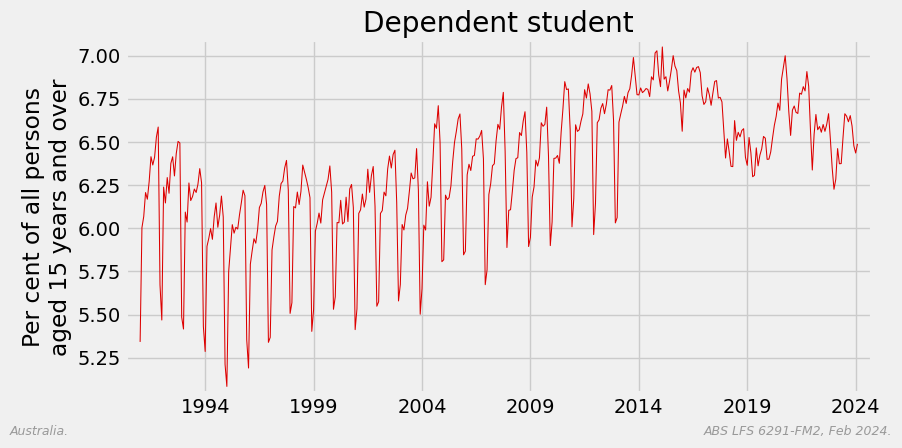

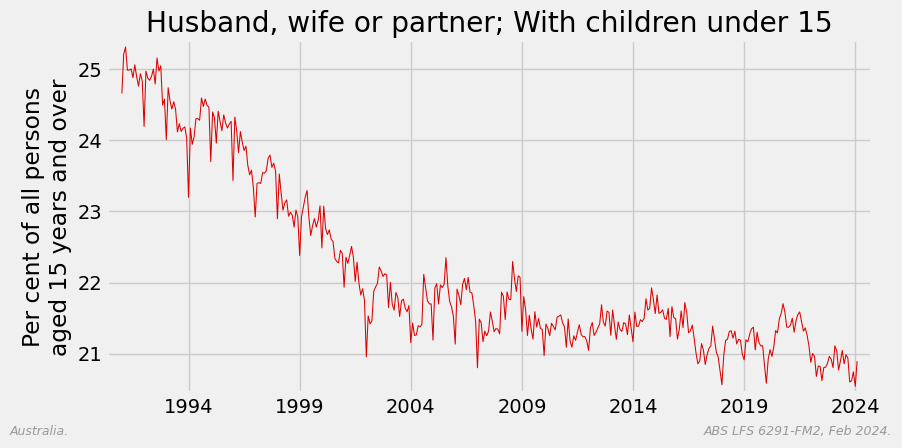

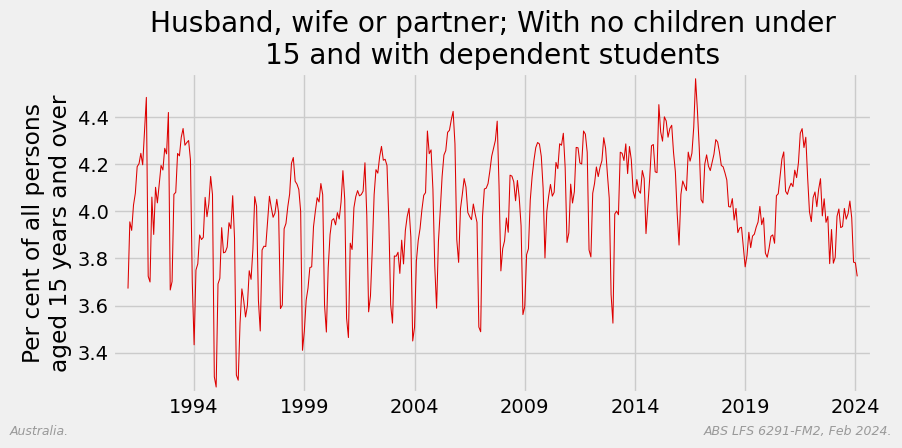

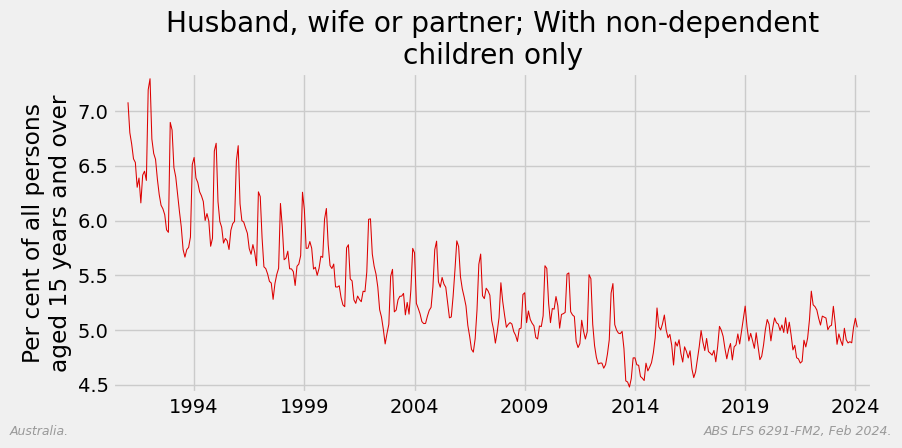

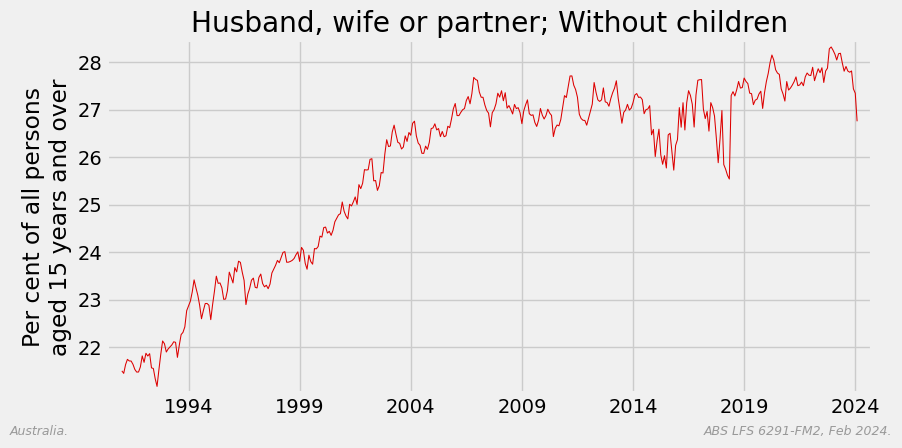

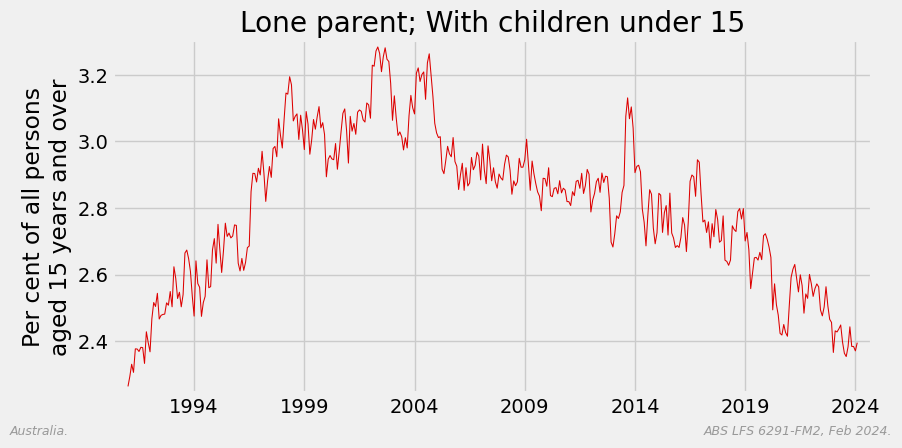

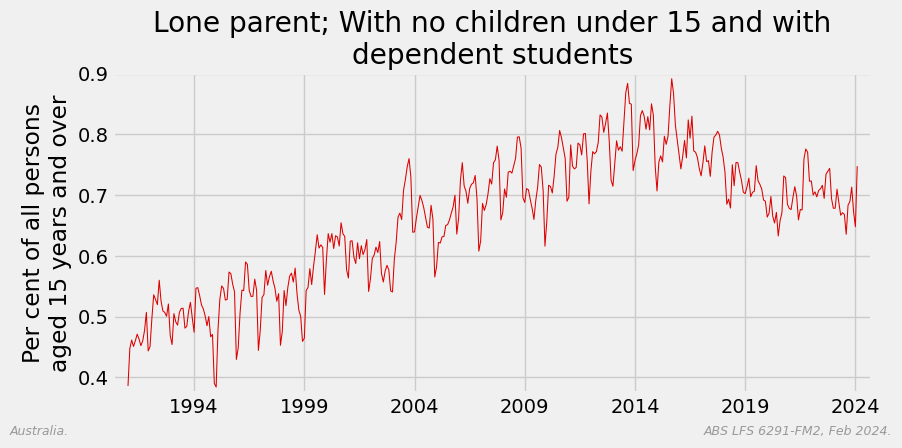

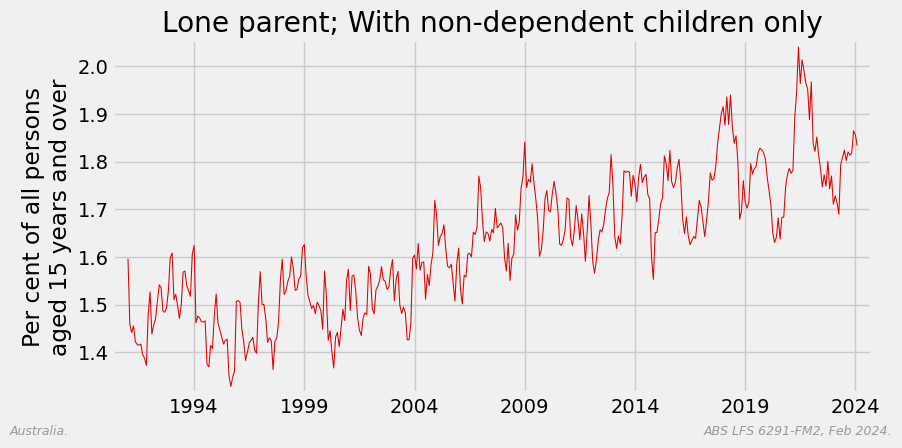

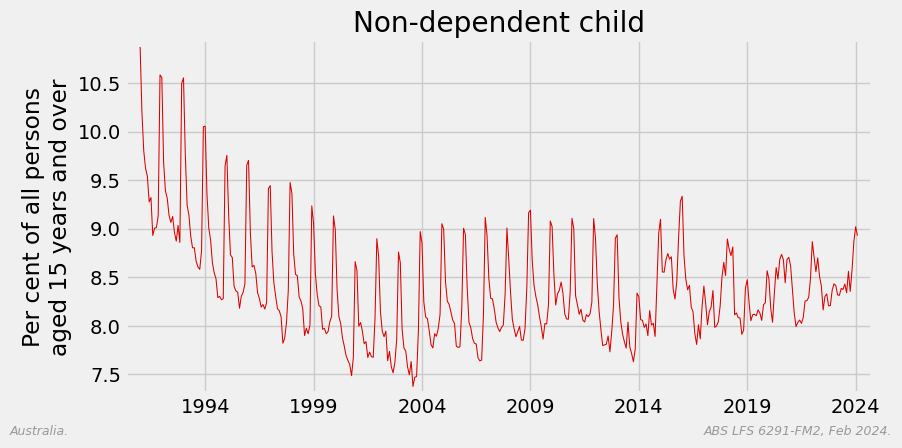

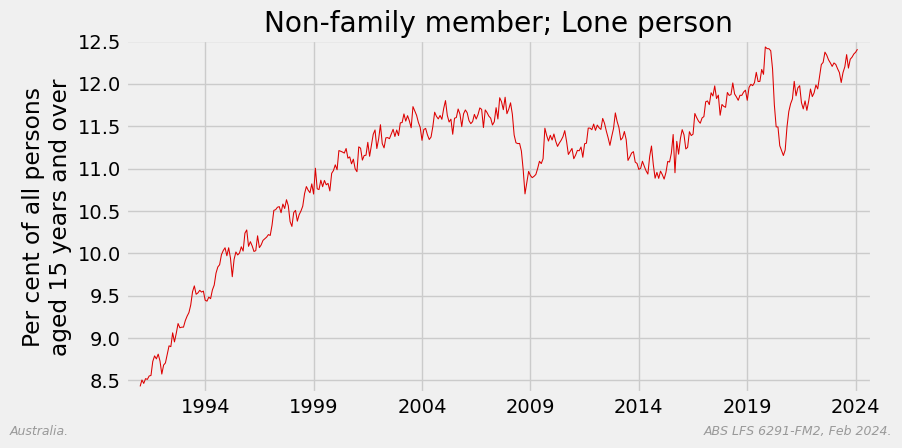

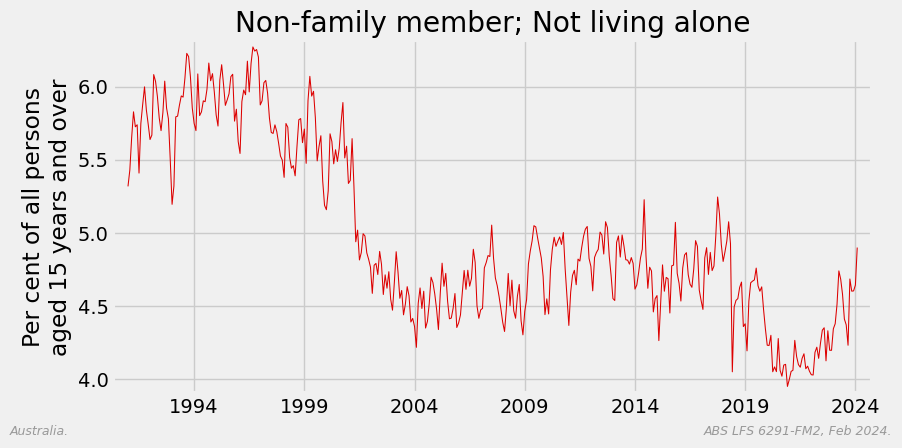

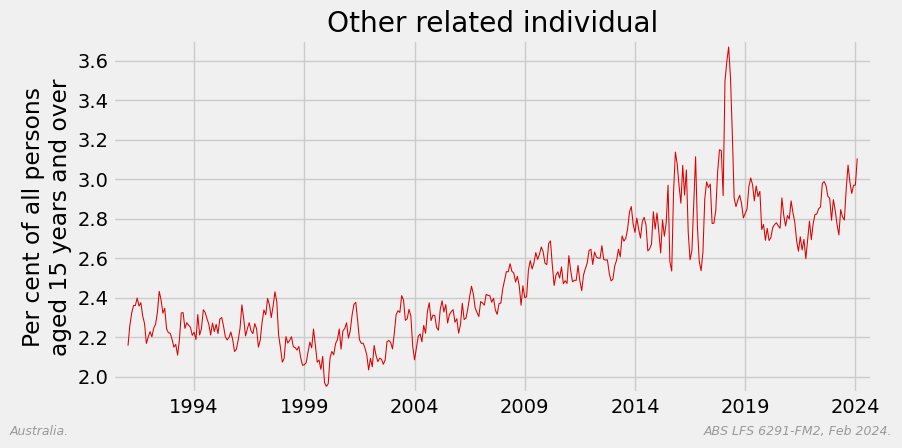

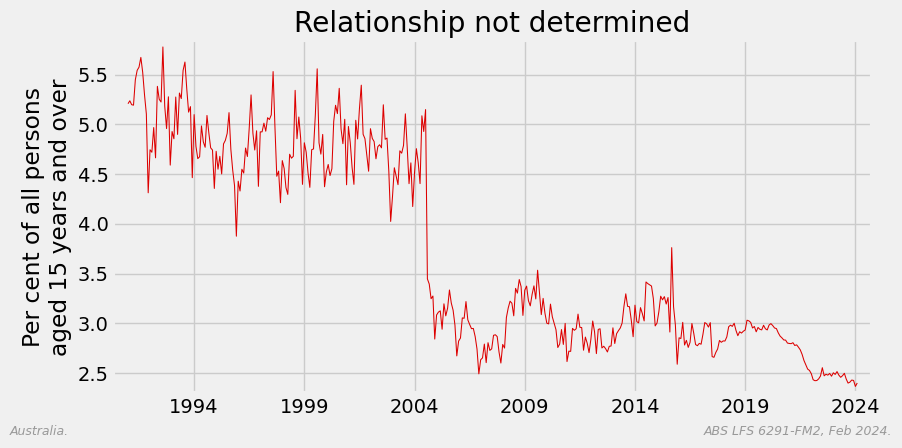

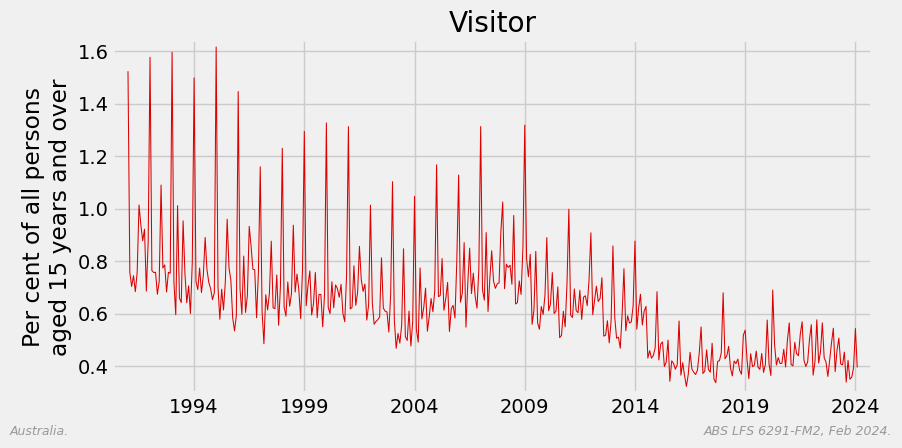

In [8]:
def chart(data: pd.DataFrame) -> None:
    """Plot the data."""
    
    long = 50  # number of characters in the title
    for col in data.columns:
        title = '\n'.join(textwrap.wrap(col, long))
        pl.line_plot(
            data[col],
            title=title,
            ylabel="Per cent of all persons\naged 15 years and over",
            xlabel=None,
            lfooter=LFOOTER,
            rfooter=RFOOTER,
            show=SHOW,
        )


chart(PP)